# Demo - Probabilistic Fourier

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using LAR
using LAR.AR
using LAR.DataAR

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Settings

In [2]:
# data loading
sound_file = "../data/obama.wav"   # specify sound location
fs_desired = 8000                 # specify desired sampling frequency

# input buffer parameters
step_size = 8                      # specify step size of buffer
buffer_size = 32                   # specify size of buffer

# probabilistic fourier parameters 
σ_observation = 0.01                # specify observation noise std
freq_bins = 15
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))

# ar modelling
AR_order = 4
iterations = 3
;

## Load data

In [21]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[24*fs_time+1:27*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)
x_time = x_time/2/maximum(x_time)

x_time = sign.(x_time) .* (log.(1 .+ 255*abs.(x_time))) ./ (log.(1 .+ 255))
# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBTZ1o+WU+lPneMmT6kL4c+CbFIPpBH7z1wN+i9LqRrvv8cir6YjoC+G0NavsTq/b3whD69G9usPbPlkD1438k9glsoPr1XLj5rIzM+hD83PksFPD7V8DI+Tb6/PWCADr6XFHu+PNKHvkUxkr4HQoS+91o+vmYLjb3o4D4+P7GZPuLosj6isrs+FT20PkwspT4PbJg+TOGLPrGvdD70GGg+6+JFPr6dnD3rkgW+68w5vnI2Lb5+LSe+yOnjvVUXGj03zYs73ZSXPehMWT4Emo8+4qiePqg2lj4kE3Y+ihOcPR0qVb5REZa+1GKsvrovvr45OcS+Lii2vnLDnr4S1Gm+EUyEvXQtFT7EyWI+wsw4PvKv1z0Pyq29Y0ApvrQQg75PnpW+/FqRvmE3dr7OpjS+84UKvlbuK77RoQi+klN6vLA5ZD3zBCk+NWg4PrnlWz4RylY+PcotPn5ybT20dRe+8NmLvuFko74iFqi+I/igvqFfhL4j5RS+9QbIPWDBZz7N0pU+gzOiPgjsmz5Rk34+Y8v/PRMklrxkzge+/ihgvntzlL77yKm+fRqzvjeksb7np6W+VKZ0vqlOD777ChE8k8TgPez7MT7Aq08+mxhLPiznQj5TdF0+5IV+PjlehD4HU2Y+VVzUPeSxBr6CFGC+8Glovpt5V75GgkG+0gz/vdZsZT0Q7kw+abKUPiIppj4knqQ+WIeTPqEvUT60oHm9ZXduvr4+lb5GBKK+8Mapvi3Xrb6Vc7K+CpuyvtsLrL7305y+4u91vpDLN755Bru9L/p+vQS4KT2rk6U9EjRhPYgiCL2KLe29UOJovuUdgr6pz4y+CTGNvsNlT76/Hb89RI2PPjk5rD7eTrc+FrmzPtV9oD7iJ4g+s7hbPvMz4j1fLwa+rBSGvuH6n74k75++pD6SvtV8fr6oEjy+vJ8HvgFNAb5Gg5C9IZC3PV8KOz4mqVw+CcZmPuUGdj62lmg+0qv3PZHeJb4815C+2r6lvlCtsL5Zo66+NleOvtNT+70ZuzM+/SiMPjLZoT5oebM+HPm5Pnyeqz5bTZ0+Tw6EPhBSPT4/8SA+stcaPlCgIj4XkRA+UfCXPaG+qryAPK28DYSSPZR7MT7oNlI+ouZWPsPNZz6LVH0+2WaTPqaAnz56gZA+3L37PRe9Or6zGoO+ZRqbvitcq76DHbe+WVitvgBUnr7bTXK+3dy9vQ0MID7oJF4+9fs8PqGFDz4nC4A9cF+0vV4pSL59EY6+GbWgviNrpL7fSJm+NeVwvu066L25A4g9QlIPPs3b/D0IHsY9T0LSPVmYwz1uKlY9FObivIhu2L3tbFy+KFiVvpzcqL5VQLK+TTGzvtz8qL77V5G+fCMzvt5Erj2Xql8+lQOhPoYwtT5Ic60+BIOLPiZNJD48vUk9/ACOvcIZHr7QVk++Mw9bvh8+ZL42iX6+0JmFvtrabL7A4ii+HCKjvdAh6j3yhzY+IfRWPoQvbT7KYXM+zeOAPoqHdz518So+T7zhPUsXsz2PT3y9SxjRvZTFxr13mBK9kLoEPrUbWD75fYo+bBKXPomckj4rtJM+p1mSPiLNgz7Vd0I+Jiw5vTJSP75FIWe+UUmCvsF9h76jfJa+Ij+evtLdnr4mMZu+J66Lvv8Vgb71nWW+oA8gvu8PPr2SCoU9adaqu0L7M745CYi+PgWkvikrs74u87G+9j2jvsFGh76AWzC+p6KlPd4YZD5Jmpk+xLihPnivlj4Ro24+tikBPrUZBT1o/A6+YkyBvuurj74reYe+IEuAvjJtW75K5j6+O3jlvYxXrzrshaY9YxsBPu47QD4JHmQ+4uByPhFqcj7vl20+RjVOPrt46D2zeAq+qgiLvvt8qb58PbS+LoGwvkl2nb5nQXO+qI3jveeHBT4jyoQ+vACWPs6Giz7wFlg+IzHkPdDbw7zX3um9kxYJvqp9pL1Y/4s87LmiPMY7TD3sbgM9vDsJvXK8jzwecEg9vgnvPerGGD62i2Y+hRKUPtg0qz4kAK4+Di6PPjgnDD6Qwyu+rCeTvuwDrr5tmLq+kA2yvpyhlr6Vwla+hGR6u1EZSj5V4IM+zkKHPkgSdz7tdUU+jsjNPZLCmb3NpRS+RLcyvk6DGL4KSxS+cmoGvliqpryN/Yg9bksZPrfZUz6N/1M+NOtAPgvWWD4+cGA+XolPPt5QPz4mOeo9kLunvf+VRb40r36+WgqLvqx/kr5NHpG+1NRyvi5Rjr2vE20+fhCiPt3Trz4tqKY+j8aEPlmCSz5XFjQ+7GYWPsciYD3XCrO9JtInvtJ3S74MBE++34c7vgK0Qb6s6VG+ufUyvvBZ+r0Fbh48EhwpPjo2dz50e44+GWaRPjIWdz62qzY+yjYRvau5N74eJXq+/H+Tvp0Gl744dpq+IB6LvrNUTL6rnMG9ShDuPWSpOD4guSw+QLIlPvB1AT5sqpk9le8MvWwRHr6+4ne+MKuMvnmVmL7kepe+vQ+VvmKVlr4Df42+ggmIvggLZ75WPR2+uo3GvZ65XDxRfCc9zULbu9pU1L3jRFq+yNyEvoP3ob7l8rS+Uz25viJEq76GWne+IJC5O+bxUz5Mi4c+R/yLPlgpjD7k03k+tl04PoDVsjztjRC+HtA+vvEWKr6fkdm8TDIwPYoZRT0AZWo9iSXZPKCqyT1o8gU+5KDhPfTj1T3uk/E88UsdPZFVMT11LKs80pnKvUp4TL5CeYe+1e+lvj8ytb4CycK+LTvFvlQ3wr6f96++YpGFvp0Sjr0DFU8+20OBPjGDij6wE5w+IW6xPmO4wj6VCsw+SyzWPhUl2j4cId4+Sj3iPt4u3j5WaNQ+q+DDPg1bsT7z2Zk+5Ph0PkijBT5NVfY8qYEEvSfvkb1a0e29w2hVvtx+mr7sVLK+/72/vn+Iyr5MCNG+JwXWvnN/0b6lrcK+pkClvmODgb5RiTa+bY/QvQdHw7rwyp497p4EPrqHPT7sM1c+Qap2PpXygj5wB4Y+mBSIPhUFjj4hs5U+2eqWPiZjjj4QcXE+MZZJPl52Gz4d65Q7aHkRviRAX76MGJi+MGq2vqQcy753Cdi+DOrYviRw1r6A6My+xUiyvgYEdb4DsKc9nv+DPq+7oj7kKbY+BqC7PigHuD549a8+i36lPluFlj7AsYs+bSCUPhRajz5S/4A+h9VjPvyvMj6H0CI+EZf4PftXRL3lsC6+3Td3vqgsiL5AhpG+3/qIvjUtib6dEZK+v3WVvswQmL7M5Ja+IYqXvpxnj74hEVe+uPYVPbncgz4M9Ks+nky9Pl5kwT7+UL0+gmetPmKGoz5juqY+/1ykPvQFnj5+i4s++ixyPqk4Sz6aMyE+DfICPfRkR75MF4m+1XGhviWFsb44u7q+DiXIviOGy77DDsq+HpDLvn5n1L58sOG+5UDsvn9Y874Ys/G+ZVvrvnai3b7iPsa+dpGbvoPb/71sBB8+KElxPgdAiT7Irok+m4aHPi4hgT4veGE+1p1DPigTHj6ktRw+x2hHPsuAcD53pXU+NTp9Po39hz5X5Yw+CiKCPgnkSD7dYuQ9wRAgPaCt2jyd+G89tnOcPaOxtzvQyH69UtMEvjFJUb4CLH++N4CCvpOBU75Llb+9Yj/HPZ8gVD7cM4I+MMePPiosiz5Cqmg+8l0lPmfkEz77Bio+mNQgPr9V4j0P0vM8PMHavViFKb6w0Fe+yP5fvvQHe75LMoi+ZemAviFja75ikFe+P04VvtkLRL3JdQ4+wNGBPvN7nT4Iiqw+ve2tPhaNqz6a2rE+dUO6PuRhyD6YNNc+rbrcPp4F3T638dY+cfnKPnJsuD5AxZ0+XF9nPrRBQj0aoWy+Z9ajvmr1w74hyN2+ZFnxvsTx+r53D

## Visualize data

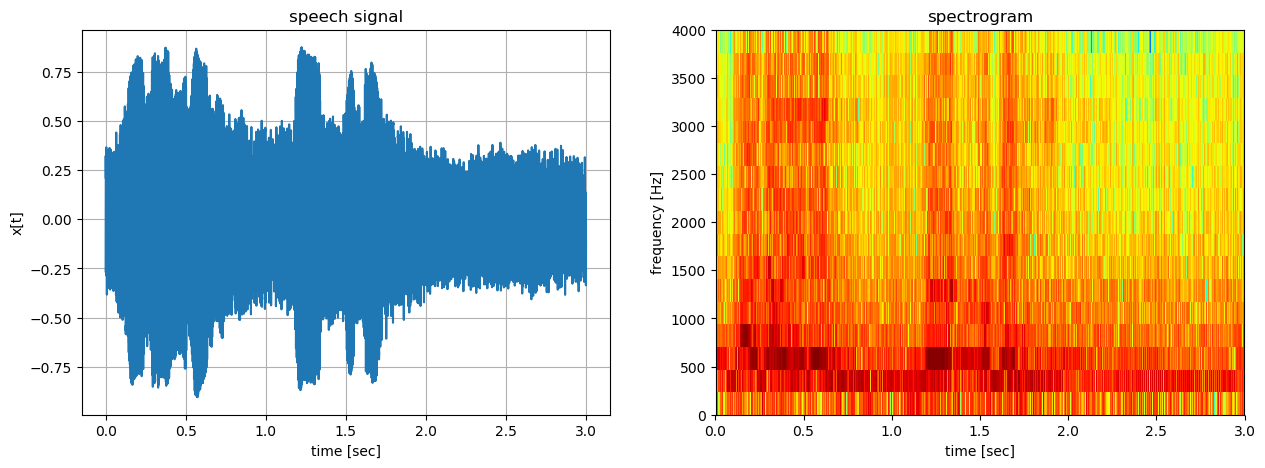

In [22]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, buffer_size, buffer_size-step_size, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [23]:
# create factor graph
fg = FactorGraph()

# placeholders
z_min = Array{Variable,1}(undef, 2*length(freq))
γ = Array{Variable,1}(undef, 2*length(freq))
θ = Array{Variable,1}(undef, 2*length(freq))
z = Array{Variable,1}(undef, 2*length(freq))

# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), σ_observation^2*Ic(buffer_size))

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min,k)] z_min[k] ~ GaussianMeanVariance(placeholder(pad(:μ_z_min, k), dims = (AR_order,)),
                                        placeholder(pad(:Σ_z_min, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:γ,k)] γ[k] ~ ForneyLab.Gamma(placeholder(pad(:a_γ,k)), placeholder(pad(:b_γ,k)))
    @RV [id=pad(:θ,k)] θ[k] ~ GaussianMeanVariance(placeholder(pad(:μ_θ,k), dims=(AR_order,)), placeholder(pad(:Σ_θ,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z,k)] z[k] ~ LAR.AR.Autoregressive(θ[k], z_min[k], γ[k])
end

# specify Fourier matrix
Ceme1 = Array{Variable,1}(undef, 2*length(freq))
for k=1:2*length(freq)
    @RV Ceme1[k] 
    placeholder(Ceme1[k], pad(:Ceme1,k), dims = (buffer_size, AR_order))
end

# specify observations
@RV x = sum(Ceme1.*z)
@RV y = x + v

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
# ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 2801845956192597047 -->
 2801845956192597047 
 
 𝒩 
 gaussianmeanvariance_48 
 
<!-- 3162099055762680045 -->
 3162099055762680045 
 
 placeholder_Σ_z_min_24 
 
<!-- 2801845956192597047--3162099055762680045 -->
 2801845956192597047--3162099055762680045 
 
 Σ_z_min_24 
 1 out 
 3 v 
 
<!-- 14740914579990475769 -->
 14740914579990475769 
 
 placeholder_μ_z_min_24 
 
<!-- 2801845956192597047--14740914579990475769 -->
 2801845956192597047--14740914579990475769 
 
 μ_z_min_24 
 1 out 
 2 m 
 
<!-- 2520146101358943974 -->
 2520146101358943974 
 
 placeholder_μ_θ_22 
 
<!-- 4137666425422490258 -->
 4137666425422490258 
 
 placeholder_Σ_z_min_29 
 
<!-- 15344832607470781707 -->
 15344832607470781707 
 
 + 
 addition_6 
 
<!-- 6708319245742788027 -->
 6708319245742788027 
 
 + 
 addition_5 
 
<!-- 15344832607470781707--6708319245742788027 -->
 15344832607470781707--6708319245742788027 
 
 variable_35 
 1 out 
 2 in1 
 
<!-- 6032915801826274570 -->
 6032915801826274570 
 
 × 
 multiplication_7 
 
<!-- 15344832607470781707--6032915801826274570 -->
 15344832607470781707--6032915801826274570 
 
 variable_7 
 1 out 
 3 in2 
 
<!-- 5439975970548487741 -->
 5439975970548487741 
 
 + 
 addition_25 
 
<!-- 8080507507283566619 -->
 8080507507283566619 
 
 × 
 multiplication_26 
 
<!-- 5439975970548487741--8080507507283566619 -->
 5439975970548487741--8080507507283566619 
 
 variable_26 
 1 out 
 3 in2 
 
<!-- 18071926085508092714 -->
 18071926085508092714 
 
 + 
 addition_24 
 
<!-- 5439975970548487741--18071926085508092714 -->
 5439975970548487741--18071926085508092714 
 
 variable_54 
 1 out 
 2 in1 
 
<!-- 13568504040112735620 -->
 13568504040112735620 
 
 placeholder_Σ_z_min_03 
 
<!-- 10735542291793526782 -->
 10735542291793526782 
 
 placeholder_b_γ_25 
 
<!-- 9234158879895310406 -->
 9234158879895310406 
 
 placeholder_Ceme1_3 
 
<!-- 1416791370692446542 -->
 1416791370692446542 
 
 placeholder_Σ_z_min_21 
 
<!-- 17888946766934588277 -->
 17888946766934588277 
 
 Gam 
 gamma_13 
 
<!-- 2394899774003903096 -->
 2394899774003903096 
 
 placeholder_b_γ_13 
 
<!-- 17888946766934588277--2394899774003903096 -->
 17888946766934588277--2394899774003903096 
 
 b_γ_13 
 1 out 
 3 b 
 
<!-- 4026478404356509529 -->
 4026478404356509529 
 
 placeholder_a_γ_13 
 
<!-- 17888946766934588277--4026478404356509529 -->
 17888946766934588277--4026478404356509529 
 
 a_γ_13 
 1 out 
 2 a 
 
<!-- 2486530904088789994 -->
 2486530904088789994 
 
 + 
 addition_21 
 
<!-- 12632063609876722480 -->
 12632063609876722480 
 
 + 
 addition_20 
 
<!-- 2486530904088789994--12632063609876722480 -->
 2486530904088789994--12632063609876722480 
 
 variable_50 
 1 out 
 2 in1 
 
<!-- 13247420891969604900 -->
 13247420891969604900 
 
 × 
 multiplication_22 
 
<!-- 2486530904088789994--13247420891969604900 -->
 2486530904088789994--13247420891969604900 
 
 variable_22 
 1 out 
 3 in2 
 
<!-- 2425555579780952326 -->
 2425555579780952326 
 
 Gam 
 gamma_17 
 
<!-- 2071238387114989402 -->
 2071238387114989402 
 
 placeholder_a_γ_17 
 
<!-- 2425555579780952326--2071238387114989402 -->
 2425555579780952326--2071238387114989402 
 
 a_γ_17 
 1 out 
 2 a 
 
<!-- 13967192572197742099 -->
 13967192572197742099 
 
 placeholder_b_γ_17 
 
<!-- 2425555579780952326--13967192572197742099 -->
 2425555579780952326--13967192572197742099 
 
 b_γ_17 
 1 out 
 3 b 
 
<!-- 1585840207653246861 -->
 1585840207653246861 
 
 placeholder_Σ_z_min_09 
 
<!-- 980805529367369222 -->
 980805529367369222 
 
 AR 
 autoregressive

In [24]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ, z, z_min, γ, ids=[:θ :z :z_min :γ])
algo = compatibility_fix(variationalAlgorithm(q))
# algo_F = freeEnergyAlgorithm(q) # throws error because the variables z are all connected

# evaluate algorith 
eval(Meta.parse(algo))
;

## Perform inference

In [25]:
messages=Array{Message}(undef, 180)
data = Dict()
marginals = Dict()

# create placeholders for priors
μ_z_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_z_min = Array{Array{Float64,2},1}(undef, 2*length(freq))
a_γ = Array{Float64,1}(undef, 2*length(freq))
b_γ = Array{Float64,1}(undef, 2*length(freq))
μ_θ = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_θ = Array{Array{Float64,2},1}(undef, 2*length(freq))

# set priors 
for k = 1:2*length(freq)
    μ_z_min[k] = zeros(AR_order)
    Σ_z_min[k] = 1e10*Ic(AR_order)
    a_γ[k] = 1
    b_γ[k] = 0.001
    μ_θ[k] = zeros(AR_order)
    Σ_θ[k] = 1e-10*Ic(AR_order)
end

# create marginals
for k = 1:2*length(freq)
    marginals[pad(:γ, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=a_γ[k], b=b_γ[k])
    marginals[pad(:θ, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_θ[k], v=Σ_θ[k])
    marginals[pad(:z_min, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_z_min[k], v=Σ_z_min[k])
end

# initialize buffer
buf = BufferData(x_time, t, buffer_size)

# initialize placeholder for hidden states and observation
μ_x = Array{Float64,1}[]
Σ_x = Array{Float64,2}[]
μ_s = Array{Float64,1}[]
Σ_s = Array{Float64,2}[]

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # fill data dictionary
    data[:y] = buf.buffer_s
    for f = 1:2*length(freq)
        C = [calc_C(freq, buf.buffer_t.-(k*step_size/fs_desired))*em(2*length(freq), f)*(em(AR_order, 1)') for k = 0:AR_order-1]
        D = zeros(size(C[1]))
        for k = 1:AR_order
            D[(k-1)*step_size + 1:k*step_size, k] = C[k][1:8,1]
        end
        data[pad(:Ceme1,f)] = D
    end
    
    # infer parameters
    for it = 1:iterations
        
        # update data
        for f = 1:2*length(freq)
            data[pad(:a_γ, f)] = a_γ[f]
            data[pad(:b_γ, f)] = b_γ[f]
            data[pad(:μ_θ, f)] = μ_θ[f]
            data[pad(:Σ_θ, f)] = Σ_θ[f]
            data[pad(:μ_z_min, f)] = μ_z_min[f]
            data[pad(:Σ_z_min, f)] = Σ_z_min[f]
        end
        
        # perform steps (z last to get prediction of x)
        marginals = Base.invokelatest(stepz!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz_min!, data, marginals, messages)
        marginals = Base.invokelatest(stepγ!, data, marginals, messages)
        marginals = Base.invokelatest(stepθ!, data, marginals, messages)

    end
    
    # run another time for prediction of x
    marginals = Base.invokelatest(stepz!, data, marginals, messages)  

    # estimate prediction of x
    push!(μ_x, ForneyLab.unsafeMean(messages[179].dist))
    push!(Σ_x, ForneyLab.unsafeCov(messages[179].dist))
    
    # get spectral component values
    push!(μ_s, [ForneyLab.unsafeMean(marginals[pad(:z, k)])[1] for k=1:2*length(freq)])
    push!(Σ_s, diagm([ForneyLab.unsafeMean(marginals[pad(:z, k)])[1,1] for k=1:2*length(freq)]))
    
    # update hidden states
    for f = 1:2*length(freq)
        μ_z_min[f] = ForneyLab.unsafeMean(marginals[pad(:z,f)])
        Σ_z_min[f] = ForneyLab.unsafeCov(marginals[pad(:z,f)])
        a_γ[f] = marginals[pad(:γ,f)].params[:a]
        b_γ[f] = marginals[pad(:γ,f)].params[:b]
        μ_θ[f] = ForneyLab.unsafeMean(marginals[pad(:θ,f)])
        Σ_θ[f] = ForneyLab.unsafeCov(marginals[pad(:θ,f)])
    end
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

Observed 100%|██████████████████████████████████████████| Time: 0:04:06


In [31]:
f = 5
C = [calc_C(freq, buf.buffer_t.-(k*step_size/fs_desired))*em(2*length(freq), f)*(em(AR_order, 1)') for k = 0:AR_order-1]
D = zeros(size(C[1]))
for k = 1:AR_order
    D[(k-1)*step_size + 1:k*step_size, k] = C[k][1:8,1]
end


In [27]:
mean(marginals[:z_05])

4-element Array{Float64,1}:
  0.0015958905889382933
 -6.366543019224777e-7 
 -6.358494713633384e-7 
 -6.089046554926695e-7 

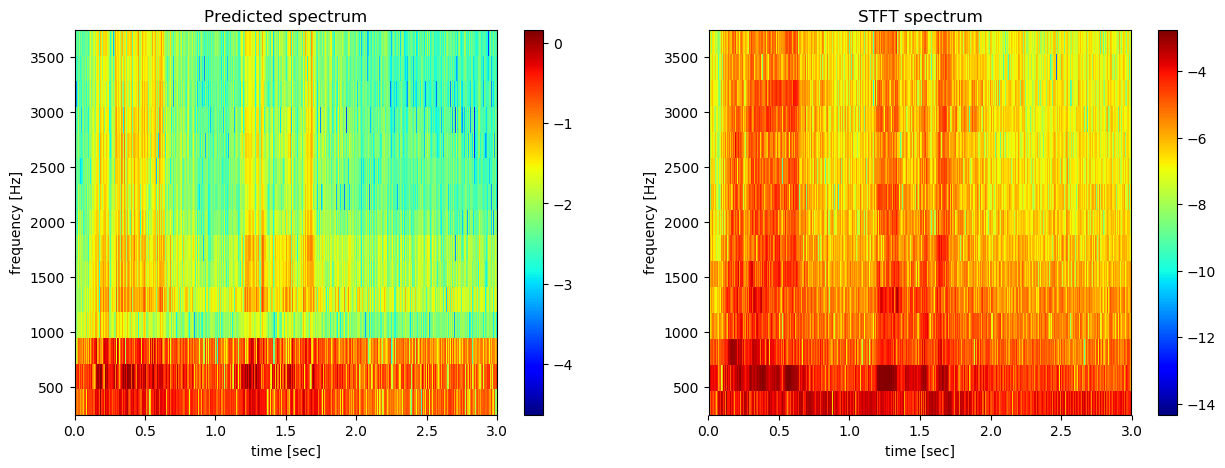

In [28]:
# convert μ_x to a 1d array
μ_x_pred = expand(reverse(hcat(μ_x...),dims=1))

# convert s_x to a 2d array
if length(size(μ_s)) != 2
    μ_s = hcat(μ_s...)
end

# calculate magnitude spectrum
mag_μ_s = log10.(sqrt.(μ_s[1:length(freq),:].^2 + μ_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_μ_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), minimum(freq), maximum(freq)])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, buffer_size, buffer_size-step_size, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[1].set_ylim(minimum(freq), maximum(freq)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
;

In [29]:
# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
μ_x_pred_norm = μ_x_pred/maximum(μ_x_pred)
println(var(μ_x_pred))

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[1:length(μ_x_pred)], μ_x_pred, label="prediction"), ax[1].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[1:length(μ_x_pred)], μ_x_pred, label="prediction"), ax[2].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-2.5, 2.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(0.55,0.56), ax[2].set_ylim(-1, 1), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

# create audioplayers
audioplayers(x_time, μ_x_pred, μ_x_pred_norm, fs=fs_desired)
;

5.5157170603505645e-12


BoundsError: BoundsError: attempt to access 24000-element Array{Float64,1} at index [1:95872]

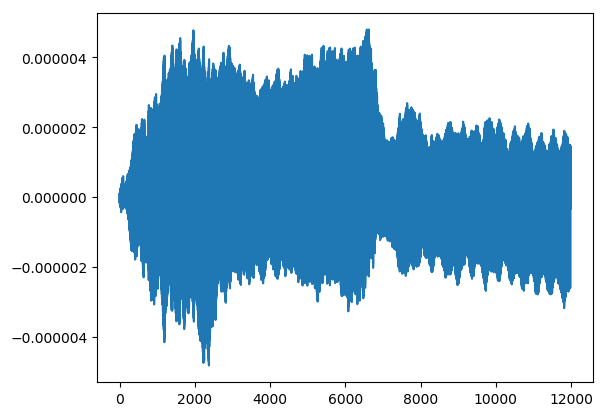

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005E596D30>

In [30]:
plt.plot(μ_x_pred[1:8:end])

## Performance metrics

In [13]:
MSE = 1/length(μ_x_pred) * sum(abs.(μ_x_pred - x_time[1:length(μ_x_pred)]).^2)

BoundsError: BoundsError: attempt to access 24000-element Array{Float64,1} at index [1:95872]

In [14]:
MAE = 1/length(μ_x_pred) * sum(μ_x_pred - x_time[1:length(μ_x_pred)])

BoundsError: BoundsError: attempt to access 24000-element Array{Float64,1} at index [1:95872]

In [15]:
using Distributions;
logBME = Float64[]
for k = 1:length(μ_x)
    try 
        push!(logBME, logpdf(Distributions.MvNormal(μ_x[k], Matrix(Hermitian(Σ_x[k]))), x_time[(k-1)*32+1:k*32]))
    catch
    end
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

nr: 750       mean:-3.5775434858838295e10

In [16]:
calc_C(freq, buf.buffer_t)*em(2*length(freq), 3)*(em(AR_order, 1)')

32×4 Array{Float64,2}:
  1.0           0.0   0.0   0.0
  0.83147       0.0   0.0   0.0
  0.382683      0.0   0.0   0.0
 -0.19509      -0.0  -0.0  -0.0
 -0.707107     -0.0  -0.0  -0.0
 -0.980785     -0.0  -0.0  -0.0
 -0.92388      -0.0  -0.0  -0.0
 -0.55557      -0.0  -0.0  -0.0
 -9.73391e-13  -0.0  -0.0  -0.0
  0.55557       0.0   0.0   0.0
  0.92388       0.0   0.0   0.0
  0.980785      0.0   0.0   0.0
  0.707107      0.0   0.0   0.0
  ⋮                            
  0.707107      0.0   0.0   0.0
  0.980785      0.0   0.0   0.0
  0.92388       0.0   0.0   0.0
  0.55557       0.0   0.0   0.0
 -1.74492e-14  -0.0  -0.0  -0.0
 -0.55557      -0.0  -0.0  -0.0
 -0.92388      -0.0  -0.0  -0.0
 -0.980785     -0.0  -0.0  -0.0
 -0.707107     -0.0  -0.0  -0.0
 -0.19509      -0.0  -0.0  -0.0
  0.382683      0.0   0.0   0.0
  0.83147       0.0   0.0   0.0